 <h1><center>Capstone Project</center></h1>
 <h1><center>(IBM Data Science)</center></h1>

 <h4><center>Ramin Hashimzade</center></h4>
 <h4><center>November 2019</center></h4>
     
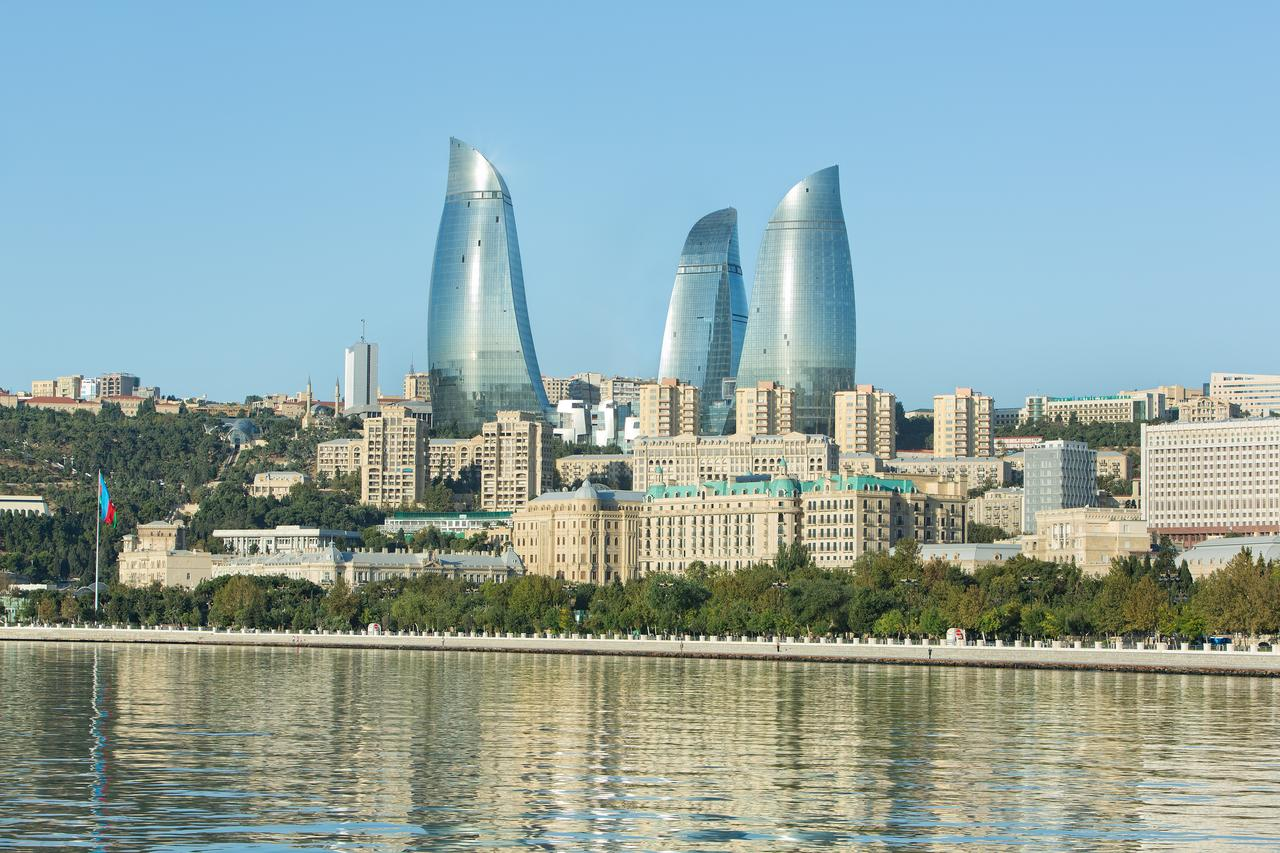

# 1. Introduction

Welcome to my final project. This notebook will delve deep into the neighborhoods of BAKU(Azerbaijan) and using the Foursquare API I will try to find venues in each neighborhood. After gathering all of the required data, analysis will follow to help cluster the different neighborhoods and gain insight into which areas are perfect for opening a new business.

# 2. Business Problem

A client would like to open a new business, however they do not know what kind of business they would like to open, let alone where to open it. In this project, I will determine the optimal areas in BAKU(Azerbaijan) to open a business, as well as the perfect business for that area.

# 3.DATA

In order to answer the business question set forth in the previous notebook, we will be gathering data from Wikipedia, Google Maps and using the Foursquare API to collect venue information for each area.The venue data collected from Foursquare will then be used to determine the top venues in each area.

Once the venue information is gathered, the next step will be to cluster areas in BAKU(Azerbaijan) based on venues categories. This information will allow us to cluster customers in each area before moving on to identify areas within the clusters which are prime candidates for a new venue, as well as identifying which specific venues would be the most lucrative.



---



---



**IMPORTING PACKAGES**


In [7]:
import pandas as pd
import numpy as np
import folium
import requests
import json

import geocoder
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

**Parsing Baku Regions to analyze location performance**


In [8]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Baku_geography_stubs").text
soup = BeautifulSoup(data, 'html.parser')

regionList = []

for row in soup.find_all("div", class_="mw-content-ltr")[0].findAll("li"):
    regionList.append(row.text)
del regionList[:3]

regions = pd.DataFrame({"Neighborhood": regionList})

regions.head()

,Neighborhood
0,Badamdar
1,Bakıxanov
2,Balaxanı
3,Baş Ələt
4,Bibiheybət


**Getting geolocations of the regions**

In [9]:
def get_latlng(university):
    coordinats = None
    while(coordinats is None):
        i = geocoder.arcgis('{}, Baku, Azerbaijan'.format(university))
        coordinats = i.latlng
    return coordinats

coordinats = [ get_latlng(university) for university in regions["Neighborhood"].tolist() ]
coordinats

[[40.361599648164855, 49.81508025040292],
 [40.43198000000007, 49.95330000000007],
 [40.46255072907915, 49.9343836061088],
 [40.410660000000064, 49.87222000000003],
 [40.33624099687983, 49.82380512464341],
 [40.44440000000003, 49.805660000000046],
 [40.410660000000064, 49.87222000000003],
 [40.410660000000064, 49.87222000000003],
 [40.466731277528304, 49.843503490449706],
 [40.35000000000008, 49.833330000000046],
 [40.372021668998926, 49.84465435423397],
 [40.51789000000008, 50.11390000000006],
 [40.49750000000006, 50.21222000000006],
 [40.283060000000035, 49.28074000000004],
 [40.320350000000076, 50.59199000000007],
 [40.320350000000076, 50.59199000000007],
 [40.316670000000045, 50.583330000000046],
 [40.44053000000008, 50.27612000000005],
 [40.433520000000044, 50.276380000000074],
 [40.38513000000006, 49.94174000000004],
 [40.410660000000064, 49.87222000000003],
 [40.410660000000064, 49.87222000000003],
 [40.410660000000064, 49.87222000000003],
 [40.401200000000074, 50.33402000000006

**Assingning geolocations to regions**


In [10]:
coordinats = pd.DataFrame(coordinats, columns=['Latitude', 'Longitude'])
regions['Latitude'] = coordinats['Latitude']
regions['Longitude'] = coordinats['Longitude']
regions.head()

,Neighborhood,Latitude,Longitude
0,Badamdar,40.361600,49.815080
1,Bakıxanov,40.431980,49.953300
2,Balaxanı,40.462551,49.934384
3,Baş Ələt,40.410660,49.872220
4,Bibiheybət,40.336241,49.823805


In [11]:
regions.shape

(81, 3)

# **As we see. Thare are 81 regions in BAKU. Now we will try to understood which regions is more flexible for new business**


## Creating the map of Baku (regions marked)

In [12]:
address = 'Baku, Azerbaijan'
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of the capital of Azerbaijan: Baku is  {}, {}.'.format(latitude, longitude))

The geograpical coordinates of the capital of Azerbaijan: Baku is  40.3754434, 49.8326748.


In [13]:
mapBaku = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(regions['Latitude'], regions['Longitude'], regions["Neighborhood"]):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(mapBaku)  
    
mapBaku

## **Foursquare API usage in exploration of neighborhoods.**

In [14]:
CLIENT_ID = "KPGGMK5WJ2E1LD1ZIJOOYIGWGWD3DI0WHRCP1N3O4VU3K4AM" 
CLIENT_SECRET = "4P4S3WE2DIUYDOAHXGKQFUPGRKQ5SQ1ETHBCPEB2DZLXAXDH" 
VERSION = '20191204' 

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: KPGGMK5WJ2E1LD1ZIJOOYIGWGWD3DI0WHRCP1N3O4VU3K4AM
CLIENT_SECRET:4P4S3WE2DIUYDOAHXGKQFUPGRKQ5SQ1ETHBCPEB2DZLXAXDH


# Explore venues from API

In [19]:
radius = 2000
LIMIT = 100

region = []

for lat, long, neighborhood in zip(regions['Latitude'], regions['Longitude'], regions['Neighborhood']):

    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for i in results:
        region.append((
            neighborhood,
            lat, 
            long, 
            i['venue']['name'], 
            i['venue']['location']['lat'], 
            i['venue']['location']['lng'],  
            i['venue']['categories'][0]['name']))

region_df = pd.DataFrame(region)

region_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(region_df.shape)
region_df.head()

(2150, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Badamdar,40.3616,49.81508,Beerbaşa,40.363921,49.818902,Brewery
1,Badamdar,40.3616,49.81508,Nakhchivan Restaurant,40.363588,49.819427,Restaurant
2,Badamdar,40.3616,49.81508,Bouquet,40.363285,49.820232,Flower Shop
3,Badamdar,40.3616,49.81508,Şəki Restoranı,40.357243,49.811641,Restaurant
4,Badamdar,40.3616,49.81508,NAR cafe,40.366750,49.815217,Hookah Bar


In [22]:
region_df["VenueCategory"].unique()

array(['Brewery', 'Restaurant', 'Flower Shop', 'Hookah Bar',
       'Comfort Food Restaurant', 'Hotel', 'Dessert Shop', 'Multiplex',
       'Beer Garden', 'Roof Deck', 'Park', 'Lounge', 'Movie Theater',
       'Soccer Field', 'Tea Room', 'Cocktail Bar', 'Spa', 'Café',
       'Historic Site', 'Museum', 'Boarding House', 'Concert Hall',
       'Music Venue', 'Coffee Shop', 'Art Gallery',
       'General Entertainment', 'Turkish Restaurant',
       'Gym / Fitness Center', 'German Restaurant', 'Plaza',
       'Italian Restaurant', 'Middle Eastern Restaurant',
       'Caucasian Restaurant', 'Pool', 'Mediterranean Restaurant',
       'BBQ Joint', 'Whisky Bar', 'Wine Bar', 'Pizza Place',
       'Kebab Restaurant', 'State / Provincial Park', 'Tennis Court',
       'Diner', 'Pub', 'Ukrainian Restaurant', 'Snack Place',
       'Theme Park Ride / Attraction', 'Office', 'Stadium', 'Gym',
       'Fast Food Restaurant', 'Department Store', 'Gas Station',
       'Eastern European Restaurant', 'Asian 

In [44]:
region_df.to_excel(r'D:\Google Drive\Colab Notebooks\venues.xlsx')

## Search Restaurants in Venues and show in map

In [25]:
restaurant_df = region_df[region_df["VenueCategory"].str.contains('Restaurant')]
restaurant_df.describe()

,Latitude,Longitude,VenueLatitude,VenueLongitude
count,518.000000,518.000000,518.000000,518.000000
mean,40.399485,49.862756,40.399078,49.859541
std,0.049750,0.280456,0.049330,0.280466
min,39.941020,46.364548,39.946943,46.357129
25%,40.372022,49.843503,40.372488,49.840388
50%,40.410660,49.872220,40.398112,49.856900
75%,40.410660,49.872220,40.414073,49.869885
max,40.704588,50.286080,40.705959,50.284070


## Draw map by category - Restaurant (blue)

In [54]:
mapBaku = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(restaurant_df['VenueLatitude'], restaurant_df['VenueLongitude'], restaurant_df["VenueCategory"]):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=False)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9).add_to(mapBaku)  
    
mapBaku

## Search Cofee Shops in Venues and show in map

In [46]:
cafe_df = region_df[region_df["VenueCategory"].str.lower().str.contains('caf')]
cafe_df.describe()

,Latitude,Longitude,VenueLatitude,VenueLongitude
count,146.000000,146.000000,146.000000,146.000000
mean,40.396941,49.903017,40.393564,49.904568
std,0.040714,0.128420,0.039139,0.129149
min,40.332550,49.624997,40.335914,49.629322
25%,40.372022,49.833330,40.370596,49.837222
50%,40.396660,49.872220,40.394311,49.861099
75%,40.410660,49.872220,40.402561,49.876033
max,40.563880,50.335290,40.574163,50.341320


## Draw map by category - Cofee (red)

In [49]:
for lat, lng, neighborhood in zip(coffee_df['VenueLatitude'], coffee_df['VenueLongitude'], coffee_df["VenueCategory"]):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9).add_to(mapBaku)  
    
mapBaku